In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1
!pip install -q h5py pyyaml

In [0]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf


import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
from glob import glob
import pathlib
import math
import cv2

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

tf.__version__

'2.0.0-rc1'

## Data load(train, validation, test)

In [0]:
PATH = "/content/gdrive/My Drive/dataset"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test= num_cats_test + num_dogs_test

print(total_train)
print(total_val)
print(total_test)

17000
4000
4000


## Visualize with each data graph

In [0]:
# 데이터 확인 함수
def check_images(train_path, val_path, test_path):
  train_cat_path = os.path.join(train_path,"cat")
  train_dog_path = os.path.join(train_path,"dog")
  val_cat_path = os.path.join(val_path,"cat")
  val_dog_path = os.path.join(val_path,"dog")
  test_cat_path = os.path.join(test_path,"cat")
  test_dog_path = os.path.join(test_path,"dog")

  num_cats_tr = len(os.listdir(train_cat_path))
  num_dogs_tr = len(os.listdir(train_dog_path))
  num_cats_val = len(os.listdir(val_cat_path))
  num_dogs_val = len(os.listdir(val_dog_path))
  num_cats_test = len(os.listdir(test_cat_path))
  num_dogs_test = len(os.listdir(test_dog_path))
  label = ['train', 'valid','test']
  cat = [num_cats_tr,num_cats_val,num_cats_test]
  dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(label))

  p1 = plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FFE6EB')
  p2 = plt.bar(x+0.15, dog, label='dog', width=0.3, color='#36E0C6')

  for i, rect in enumerate(p1):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(cat[i]), ha='center')
  for i, rect in enumerate(p2):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(dog[i]), ha='center')
  plt.legend((p1[0], p2[0]), ('1','0'), fontsize = 15)

  plt.xticks(x, label)
  plt.ylabel('Number of data')
  plt.title('Dogs-vs-Cats Data')

  plt.show()
  return

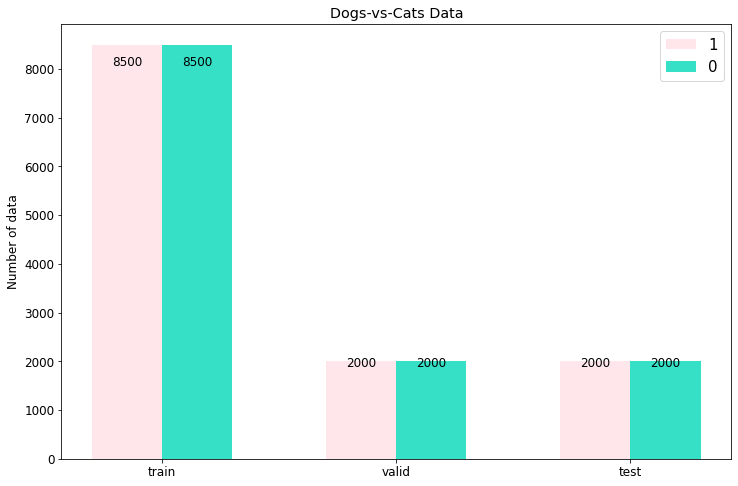

In [0]:
check_images(train_dir, validation_dir, test_dir)

## Hyperparameter initialization and dataset, load configuration

In [0]:
#하이퍼파라미터 초기화
batch_size = 20
epochs = 300
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
train_image_generator = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, rescale=1./255)

In [0]:
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 17000 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 4000 images belonging to 2 classes.


In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 4000 images belonging to 2 classes.


## Model design, detailed configuration of model-related parameter(optimization, loss function, metrics, etc.)

In [0]:
def swish(x):
    return x * tf.nn.sigmoid(x)


def round_filters(filters, multiplier):
    depth_divisor = 8
    min_depth = None
    min_depth = min_depth or depth_divisor
    filters = filters * multiplier
    new_filters = max(min_depth, int(filters + depth_divisor / 2) // depth_divisor * depth_divisor)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)


def round_repeats(repeats, multiplier):
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


class SEBlock(tf.keras.layers.Layer):
    def __init__(self, input_channels, ratio=0.25):
        super(SEBlock, self).__init__()
        self.num_reduced_filters = max(1, int(input_channels * ratio))
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        self.reduce_conv = tf.keras.layers.Conv2D(filters=self.num_reduced_filters,
                                                  kernel_size=(1, 1),
                                                  strides=1,
                                                  padding="same")
        self.expand_conv = tf.keras.layers.Conv2D(filters=input_channels,
                                                  kernel_size=(1, 1),
                                                  strides=1,
                                                  padding="same")

    def call(self, inputs, **kwargs):
        branch = self.pool(inputs)
        branch = tf.expand_dims(input=branch, axis=1)
        branch = tf.expand_dims(input=branch, axis=1)
        branch = self.reduce_conv(branch)
        branch = swish(branch)
        branch = self.expand_conv(branch)
        branch = tf.nn.sigmoid(branch)
        output = inputs * branch
        return output
        

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg= tf.keras.layers.GlobalAveragePooling2D()
        self.max= tf.keras.layers.GlobalMaxPooling2D()
        self.conv1 = tf.keras.layers.Conv2D(filters = in_planes//ratio, 
                                   kernel_size=1,
                                   kernel_initializer='he_normal', 
                                   strides=1,
                                   padding='same')
        
        self.conv2 = tf.keras.layers.Conv2D(filters = in_planes, 
                                            kernel_size=1,
                                            kernel_initializer='he_normal', 
                                            strides=1, 
                                            padding='same')
                                   
    def call(self, inputs):
        avg = self.avg(inputs)
        max = self.max(inputs)
        avg = tf.keras.layers.Reshape((1, 1, avg.shape[1]))(avg)   # shape (None, 1, 1 feature)
        max = tf.keras.layers.Reshape((1, 1, max.shape[1]))(max)   # shape (None, 1, 1 feature)
        avg_out = self.conv2(self.conv1(avg))
        avg_out = tf.nn.relu(avg_out)
        max_out = self.conv2(self.conv1(max))
        max_out = tf.nn.relu(max_out)
        out = avg_out + max_out
        out = tf.nn.sigmoid(out)

        return out

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters = 1,
                                            kernel_size = kernel_size,
                                            kernel_initializer='he_normal',
                                            strides = 1,
                                            padding='same')
    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs, axis=3)
        out = tf.stack([avg_out, max_out], axis=3)
        out = self.conv1(out)
        out = tf.nn.relu(out)

        return out

class ConvBlockAttentionModule(tf.keras.layers.Layer):
    def __init__(self, out_channels, ratio = 16, kernel_size = 7):
        super(ConvBlockAttentionModule, self).__init__()
        self.ca = ChannelAttention(in_planes = out_channels,
                                  ratio = ratio)
        self.sa = SpatialAttention(kernel_size= kernel_size)

    def call(self, inputs, **kwargs):
      out = self.ca(inputs) * inputs
      out = self.sa(out) * out

      return out


class MBConv(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, expansion_factor, stride, k, drop_connect_rate, use_se=True, use_cbam=False):
        super(MBConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.drop_connect_rate = drop_connect_rate
        self.conv1 = tf.keras.layers.Conv2D(filters=in_channels * expansion_factor,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dwconv = tf.keras.layers.DepthwiseConv2D(kernel_size=(k, k),
                                                      strides=stride,
                                                      padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()

        #Convolution Attention Block
        self.use_se = use_se
        self.se = SEBlock(input_channels=in_channels * expansion_factor)
        self.use_cbam = use_cbam
        self.cbam = ConvBlockAttentionModule(out_channels=in_channels * expansion_factor)

        self.conv2 = tf.keras.layers.Conv2D(filters=out_channels,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(rate=drop_connect_rate)

    def call(self, inputs, training=None, **kwargs):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = swish(x)
        x = self.dwconv(x)
        x = self.bn2(x, training=training)
        if self.use_se == True:
            x = self.se(x)
        if self.use_cbam == True:
            x = self.cbam(x)

        x = swish(x)
        x = self.conv2(x)
        x = self.bn3(x, training=training)
        if self.stride == 1 and self.in_channels == self.out_channels:
            if self.drop_connect_rate:
                x = self.dropout(x, training=training)
            x = tf.keras.layers.add([x, inputs])
        return x


def build_mbconv_block(in_channels, out_channels, layers, stride, expansion_factor, k, drop_connect_rate, use_se=True, use_cbam=False):
    block = tf.keras.Sequential()
    for i in range(layers):
        if i == 0:
            block.add(MBConv(in_channels=in_channels,
                             out_channels=out_channels,
                             expansion_factor=expansion_factor,
                             stride=stride,
                             k=k,
                             drop_connect_rate=drop_connect_rate,
                             use_se=use_se,
                             use_cbam=use_cbam))
        else:
            block.add(MBConv(in_channels=out_channels,
                             out_channels=out_channels,
                             expansion_factor=expansion_factor,
                             stride=1,
                             k=k,
                             drop_connect_rate=drop_connect_rate,
                             use_se=use_se,
                             use_cbam=use_cbam))
    return block


input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')

def EfficientNet(input_data, width_coefficient, depth_coefficient, dropout_rate, drop_connect_rate=0.2, use_se=True, use_cbam=False, classes=1):
  x = Conv2D(filters=round_filters(32, width_coefficient), kernel_size=(3, 3), strides=2, padding="same")(input_data)
  x = BatchNormalization()(x)
  x = build_mbconv_block(in_channels=round_filters(32, width_coefficient), out_channels=round_filters(16, width_coefficient), layers=round_repeats(1, depth_coefficient), stride=1, expansion_factor=1, k=3, drop_connect_rate=drop_connect_rate, use_se=use_se, use_cbam=use_cbam)(x)
  x = build_mbconv_block(in_channels=round_filters(16, width_coefficient), out_channels=round_filters(24, width_coefficient), layers=round_repeats(2, depth_coefficient), stride=2, expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate, use_se=use_se, use_cbam=use_cbam)(x)
  x = build_mbconv_block(in_channels=round_filters(24, width_coefficient), out_channels=round_filters(40, width_coefficient), layers=round_repeats(2, depth_coefficient), stride=2, expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate, use_se=use_se, use_cbam=use_cbam)(x)
  x = build_mbconv_block(in_channels=round_filters(40, width_coefficient), out_channels=round_filters(80, width_coefficient), layers=round_repeats(3, depth_coefficient), stride=2, expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate, use_se=use_se, use_cbam=use_cbam)(x)
  x = build_mbconv_block(in_channels=round_filters(80, width_coefficient), out_channels=round_filters(112, width_coefficient), layers=round_repeats(3, depth_coefficient), stride=1, expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate, use_se=use_se, use_cbam=use_cbam)(x)
  x = build_mbconv_block(in_channels=round_filters(112, width_coefficient), out_channels=round_filters(192, width_coefficient), layers=round_repeats(4, depth_coefficient), stride=2, expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate, use_se=use_se, use_cbam=use_cbam)(x)
  x = build_mbconv_block(in_channels=round_filters(192, width_coefficient), out_channels=round_filters(320, width_coefficient), layers=round_repeats(1, depth_coefficient), stride=1, expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate, use_se=use_se, use_cbam=use_cbam)(x)
  x = Conv2D(filters=round_filters(1280, width_coefficient), kernel_size=(1, 1), strides=1, padding="same")(x)
  x = BatchNormalization()(x)
  x = GlobalAveragePooling2D()(x)
  if dropout_rate:
    x = Dropout(drop_connect_rate)(x)
  if classes != 1:
    x = Dense(units=classes, activation=tf.keras.activations.softmax)(x)
  else:
    x = Dense(units=classes, activation=tf.keras.activations.sigmoid)(x)

  return Model(input_data, x)


def get_efficient_net(input_tensor, width_coefficient=1.0, depth_coefficient=1.0, resolution=224, dropout_rate=0.2, use_se=True, use_cbam=False, classes=1):
    net = EfficientNet(input_data = input_tensor, width_coefficient=width_coefficient,
                       depth_coefficient=depth_coefficient,
                       dropout_rate=dropout_rate,
                       use_se=use_se, 
                       use_cbam=use_se,
                       classes=classes)

    return net

In [0]:
def efficient_net_b0(classes):
    return get_efficient_net(input_tensor, 1.0, 1.0, 224, 0.2, classes=classes)


def efficient_net_b1(classes):
    return get_efficient_net(input_tensor, 1.0, 1.1, 240, 0.2, classes=classes)


def efficient_net_b2(classes):
    return get_efficient_net(input_tensor, 1.1, 1.2, 260, 0.3, classes=classes)


def efficient_net_b3(classes):
    return get_efficient_net(input_tensor, 1.2, 1.4, 300, 0.3, classes=classes)


def efficient_net_b4(classes):
    return get_efficient_net(input_tensor, 1.4, 1.8, 380, 0.4, classes=classes)


def efficient_net_b5(classes):
    return get_efficient_net(input_tensor, 1.6, 2.2, 456, 0.4, classes=classes)


def efficient_net_b6(classes):
    return get_efficient_net(input_tensor, 1.8, 2.6, 528, 0.5, classes=classes)


def efficient_net_b7(classes):
    return get_efficient_net(input_tensor, 2.0, 3.1, 600, 0.5, classes=classes)


In [0]:
efficientnet_b0 = efficient_net_b0(1)

In [0]:
optimizer = optimizers.SGD(lr=0.001, momentum=0.9)

efficientnet_b0.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
efficientnet_b0.build(input_shape = (None, IMG_HEIGHT, IMG_WIDTH, 3))

In [0]:
efficientnet_b0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
sequential (Sequential)      (None, 112, 112, 16)      2776      
_________________________________________________________________
sequential_1 (Sequential)    (None, 56, 56, 24)        30828     
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 40)        81904     
_________________________________________________________________
sequential_3 (Sequential)    (None, 14, 14, 80)        467100

## Model training (with parameters such as checkpoints, steps, epochs, data, etc.)

In [0]:
history = efficientnet_b0.fit_generator(
    train_data_gen,
    steps_per_epoch = 80,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps = 20
)

In [0]:
import pickle
with open('/content/gdrive/My Drive/github_modelNet/all_efficientnet_sgd_300_history.bin', 'wb') as hi:
    pickle.dump(history.history, hi)

In [0]:
efficientnet_b0.save_weights('/content/gdrive/My Drive/github_modelNet/all_efficientnet_sgd_300', save_format='tf')


## View model learning graphs (300 epochs)

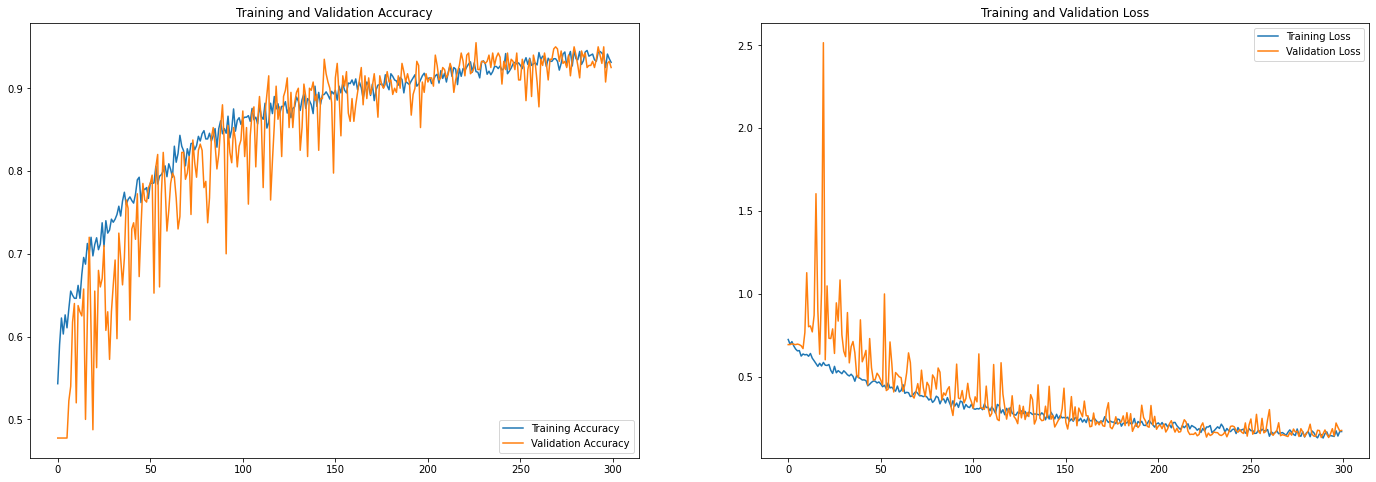

In [0]:
#300 epoch commit graph(train, validation - accracy, loss value)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Assess learning model and confirm prediction

In [0]:
efficientnet_b0.load_weights('/content/gdrive/My Drive/dataset/efficientnet_b0_300')

In [0]:
# epoch 300
print("Evaluate")
scores = efficientnet_b0.evaluate_generator(test_data_gen, steps=200)
print("%s: %.2f%%" %(efficientnet_b0.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(efficientnet_b0.metrics_names[0], scores[0]*100))

Evaluate
accuracy: 94.65%
loss: 13.21%


In [0]:
print("Predict")
pred = efficientnet_b0.predict_generator(test_data_gen, steps=200, verbose=1)

Predict
200/200 [==============================] - 38s 192ms/step


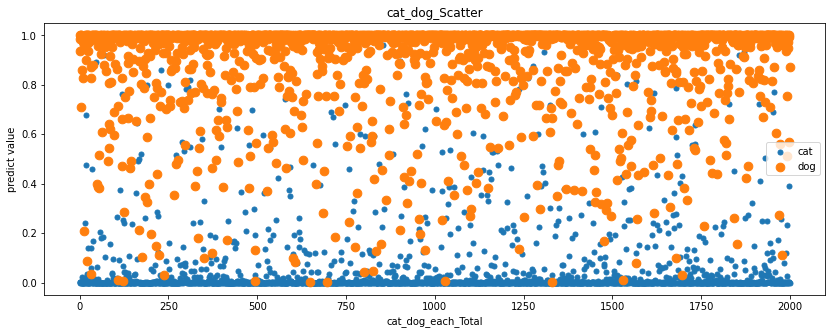

In [0]:
#test predict 예측값 분포도(4000개)

plt.figure(figsize=(14, 5))
plt.title('cat_dog_Scatter')
plt.xlabel('cat_dog_each_Total')
plt.ylabel('predict value')
plt.scatter(range(2000), pred[:2000], s=25, label = 'cat') #고양이
plt.scatter(range(2000), pred[2000:], s= 75, label = 'dog') #개
plt.legend()
plt.show()

In [0]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(33.0, 0.5, 'true value')

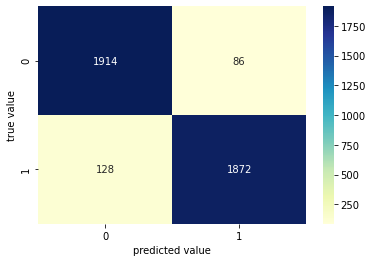

In [0]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(test_data_gen.classes, predict_data4)
#print(conf_matrix)
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

## Feature map (one layer or one layer each).

Using TensorFlow backend.


(1, 224, 224, 3)


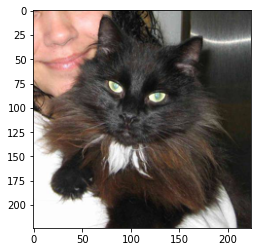

In [0]:
#feature map 
from keras.preprocessing import image as keras_image

#test_image 한개 접근
test_image = Image.open('/content/gdrive/My Drive/dataset/test/cat/cat.89.jpg').resize((224, 224))

img_tensor = image.img_to_array(test_image)
img_tensor = np.expand_dims(img_tensor, axis=0)
test_data = img_tensor / 255.0

plt.imshow(test_image)

print(test_data.shape)

In [0]:
#모델 예측 확인

pred_test = efficientnet_b0.predict(test_data)

pred_test

array([[0.]], dtype=float32)

In [0]:
feature_model = Sequential()

In [0]:
def Layer_predict(model, image):
  output_layers = [layer.output for layer in model.layers[1:15]]
  output_names = [layer.name for layer in model.layers[1:15]]

  show_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
  # 예측_A
  show_model_pred = show_model.predict(image)
  #print(model_A_pred[0])
  for pred_layer in show_model_pred:
    print(pred_layer.shape)
  return show_model_pred, output_names

In [0]:
layer_outputs, layer_names = Layer_predict(efficientnet_b0, test_data)

(1, 112, 112, 32)
(1, 112, 112, 32)
(1, 112, 112, 16)
(1, 56, 56, 24)
(1, 28, 28, 40)
(1, 14, 14, 80)
(1, 14, 14, 112)
(1, 7, 7, 192)
(1, 7, 7, 320)
(1, 7, 7, 1280)
(1, 7, 7, 1280)
(1, 1280)
(1, 1280)
(1, 1)


In [0]:
def show_predict_image(show_model_pred, output_names):
    n_col= 8
    #print(show_model_pred.shape)
    if show_model_pred.ndim == 4:
      _, size2, size, n_features = show_model_pred.shape
      n_row = n_features // n_col
      # feature_map_image = np.zeros(shape=(size2*n_row,size*n_col),dtype=('uint8'))
      feature_map_image = np.zeros(shape=(size2,size*n_col),dtype=('uint8'))
      
      for row in range(1):
          for col in range(n_col):   
              input_fmi = show_model_pred[0,:,:,row*n_col+col]

              input_fmi -= input_fmi.mean()
              input_fmi /= input_fmi.std()
              input_fmi *= 64
              input_fmi += 128
              input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

              feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

      plt.figure(figsize=(n_col, n_row))
      plt.xticks([])
      plt.yticks([])
      plt.title('layer : {}'.format(output_names))
      plt.tight_layout()
      plt.imshow(feature_map_image,cmap='viridis')

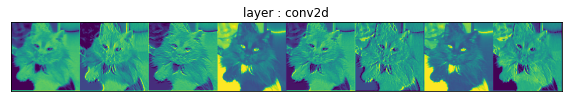

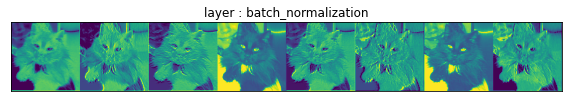

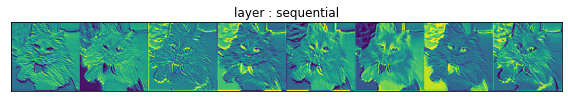

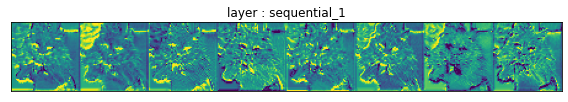

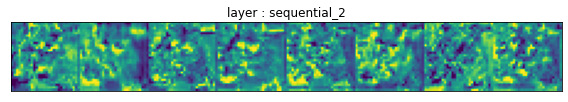

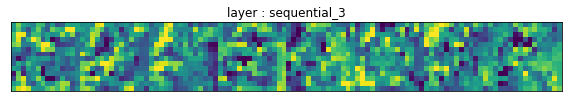

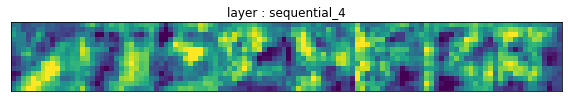

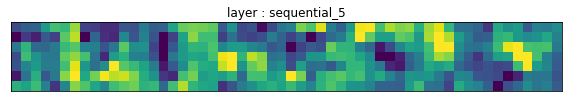

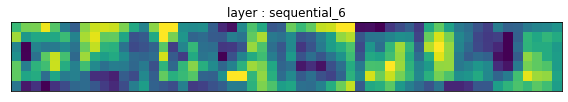

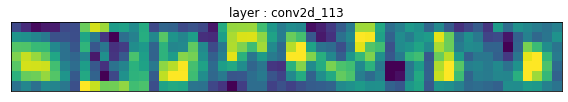

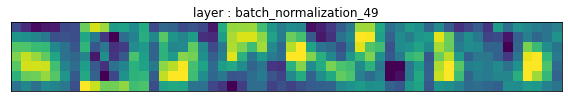

In [0]:
for layer, name in zip(layer_outputs, layer_names):
  show_predict_image(layer, name)
plt.tight_layout()
plt.show()

In [0]:
#각 층의 1개의 피쳐 맵 가져오기
def show_activation_maps(layer, title, i, n_cols=16):
  if layer.ndim == 4:
    plt.subplot(2, 6, i+1)
    plt.title('{}:{}'.format(i, title))
    plt.axis('off')
    plt.matshow(layer[0, :, :, i], fignum=0)

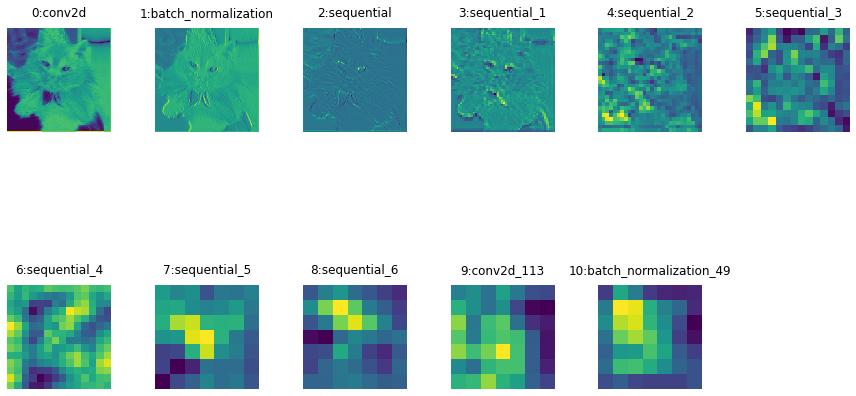

In [0]:
plt.figure(figsize=(12, 8))
for i, (layer, name) in enumerate(zip(layer_outputs, layer_names)):
  
  show_activation_maps(layer, name, i)
plt.tight_layout()
plt.show()

## Grad CAM(cat, dog)

In [0]:
for i in range(15):
  weights = efficientnet_b0.get_layer(index=i).output

  print(i, weights)

0 Tensor("input:0", shape=(None, 224, 224, 3), dtype=float32)
1 Tensor("conv2d/Identity:0", shape=(None, 112, 112, 32), dtype=float32)
2 Tensor("batch_normalization/Identity:0", shape=(None, 112, 112, 32), dtype=float32)
3 Tensor("sequential/Identity:0", shape=(None, 112, 112, 16), dtype=float32)
4 Tensor("sequential_1/Identity:0", shape=(None, 56, 56, 24), dtype=float32)
5 Tensor("sequential_2/Identity:0", shape=(None, 28, 28, 40), dtype=float32)
6 Tensor("sequential_3/Identity:0", shape=(None, 14, 14, 80), dtype=float32)
7 Tensor("sequential_4/Identity:0", shape=(None, 14, 14, 112), dtype=float32)
8 Tensor("sequential_5/Identity:0", shape=(None, 7, 7, 192), dtype=float32)
9 Tensor("sequential_6/Identity:0", shape=(None, 7, 7, 320), dtype=float32)
10 Tensor("conv2d_113/Identity:0", shape=(None, 7, 7, 1280), dtype=float32)
11 Tensor("batch_normalization_49/Identity:0", shape=(None, 7, 7, 1280), dtype=float32)
12 Tensor("global_average_pooling2d_32/Identity:0", shape=(None, 1280), dtype

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less_equal


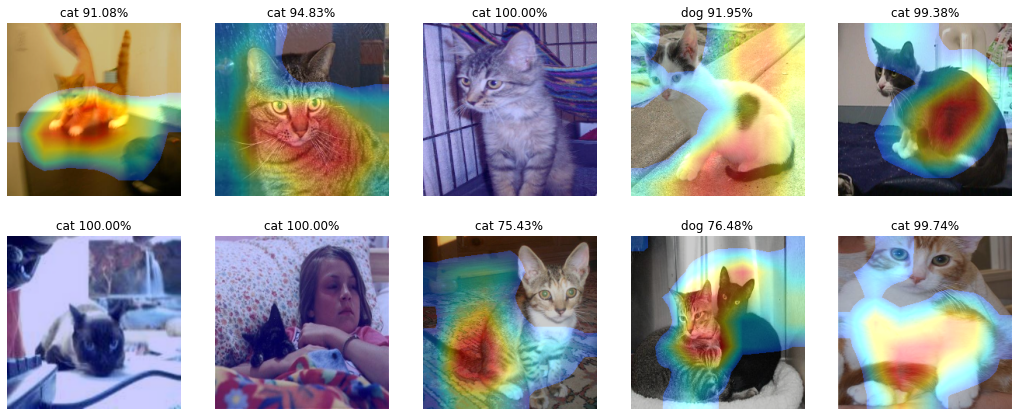

In [0]:
plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    #print(img.shape)  
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [efficientnet_b0.inputs], [efficientnet_b0.get_layer(index=10).output, efficientnet_b0.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads = tape.gradient(loss, model_outputs)

  guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  prediction = predictions[0]
  model_outputs = model_outputs[0]
  plt.subplot(4, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads, axis=(1, 2))
  weights = weights.reshape(1280, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.2
  cam /= 0.8

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    #print(cam.shape)
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less_equal


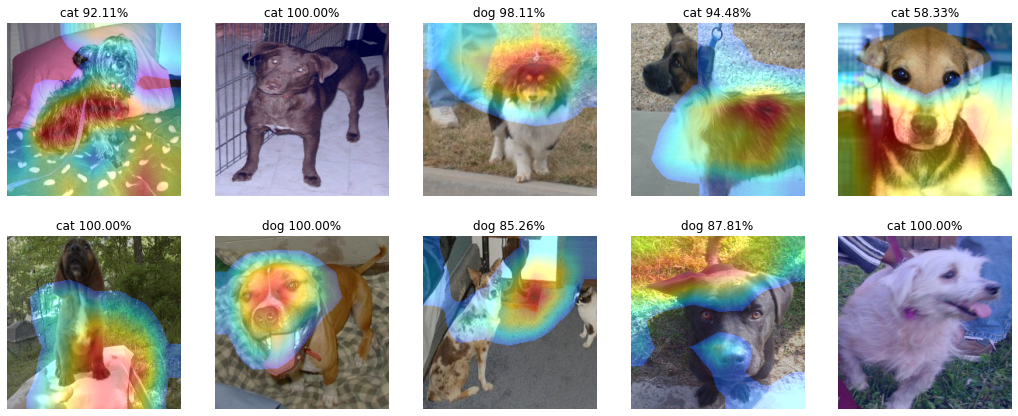

In [0]:
plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/dog/dog.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    #print(img.shape)  
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [efficientnet_b0.inputs], [efficientnet_b0.get_layer(index=10).output, efficientnet_b0.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads = tape.gradient(loss, model_outputs)

  guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  prediction = predictions[0]
  model_outputs = model_outputs[0]
  plt.subplot(4, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads, axis=(1, 2))
  weights = weights.reshape(1280, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.2
  cam /= 0.8

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    #print(cam.shape)
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])